In [1]:
from pymongo import ASCENDING, GEOSPHERE, MongoClient
import pandas as pd
from alive_progress import alive_bar
from shapely.geometry import Point, mapping
from keplergl import KeplerGl
import shapely
import json
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
import geopandas as gpd
from h3 import h3
import math
import sklearn
import numpy as np
import time

In [2]:
client = MongoClient('mongodb://localhost:27017/')
db = client.osmDataDB
coll_results = db.experimentsResults
# coll_results_rf = db.experimentsResultsBalancedRF

In [4]:
coll_results.find({}).distinct('city')

['Barcelona',
 'Berlin',
 'Bruxelles',
 'Budapest',
 'Dublin',
 'Helsinki',
 'Lyon',
 'Poznań',
 'Prague',
 'Warszawa',
 'Wrocław']

In [3]:
# 58 59 46 47 3 2 10 8 17 25 32
# Barcelona, Berlin, Bruxelles, Budapest, Dublin, Helsinki, Lyon, Poznań, Prague, Warsaw, Wrocław
results = [r for r in coll_results.find({'city': { '$in': ['Barcelona', 'Berlin', 'Bruxelles', 'Budapest', 'Dublin', 'Helsinki', 'Lyon', 'Poznań', 'Prague', 'Warszawa', 'Wrocław']}})]
# results_rf = [r for r in coll_results_rf.find({'city': { '$in': ['Barcelona', 'Berlin', 'Budapest', 'Poznań', 'Prague', 'Warsaw', 'Wrocław']}})]

In [5]:
len(results)

7019

In [6]:
# neighbour_embedding_cls_dict = {
#     'AverageDiminishingSquqredNeighbourEmbedding': 'Average Diminishing Squared Neighbour Embedding',
#     'ConcatenateNeighbourEmbedding': 'Concatenate Neighbour Embedding',
#     'AverageDiminishingNeighbourEmbedding': 'Average Diminishing Neighbour Embedding',
#     'AverageNeighbourEmbedding': 'Average Neighbour Embedding',
# }
processing_dict = {
    # 'None': 'None',
    'MinMaxScaler': 'Normalisation',
    # 'StandardScaler': 'Standardisation'
}
# processing_dict_rev = {
#     0: 'None',
#     1: 'Normalization',
#     2: 'Standardization'
# }
neighbour_embedding_cls_dict = {
    'AverageDiminishingSquqredNeighbourEmbedding': 'Average Diminishing Squared',
    'ConcatenateNeighbourEmbedding': 'Concatenate',
    # 'AverageDiminishingNeighbourEmbedding': 'Average Diminishing',
    # 'AverageNeighbourEmbedding': 'Average',
}
embedding_cls_dict = {
    'BaseCountCategoryEmbedding': 'Count Category',
    # 'BaseShapeAnalyzerEmbedding': 'Shape Analyzer',
    # 'PerCategoryShapeAnalyzerEmbedding300': 'All Tags\nShape Analyzer [300]',
    # 'PerCategoryFilteredShapeAnalyzerEmbedding300': 'Selected Tags\nShape Analyzer [300]'
}
metric_dict = {
    'accuracy': 'Accuracy',
    'f1_score': 'F1 Score',
    'custom_metric': 'Custom metric',
    'balanced_accuracy': 'Balanced accuracy',
    'precision': 'Precision',
    'recall': 'Recall',
}
parsed_results = []
flat_parsed_results = []
for r in results:
    for it in r['results']:
        if (r['neighbours'] == 0 or r['neighbour_embedding_cls'] == 'AverageDiminishingSquqredNeighbourEmbedding') and \
            r['embedding_cls'] in embedding_cls_dict and \
            r['inbalance_ratio'] == 2.5 and \
            r['x_processing'] in processing_dict:
            for metric in ['accuracy', 'custom_metric', 'f1_score', 'balanced_accuracy', 'precision', 'recall']:
                c = 'Warsaw'
                if r['city'] != 'Warszawa':
                    c = r['city']
                flat_parsed_results.append({
                    'city': c,
                    'resolution': r['resolution'],
                    'inbalance_ratio': r['inbalance_ratio'],
                    'embedding_cls': embedding_cls_dict[r['embedding_cls']],
                    'neighbours': r['neighbours'],
                    'neighbour_embedding_cls': neighbour_embedding_cls_dict[r['neighbour_embedding_cls']],
                    'processing': processing_dict[r['x_processing']],
                    'classfier_cls': it['classfier_cls'],
                    'iteration': it['iteration'],
                    'dataset_type': it['dataset_type'],
                    'metric': metric_dict[metric],
                    'value': it[metric],
                })

In [7]:
df_flat = pd.DataFrame(flat_parsed_results)
df_flat = df_flat.sort_values(by=['city', 'metric'])

In [8]:
df_flat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54120 entries, 0 to 54119
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   city                     54120 non-null  object 
 1   resolution               54120 non-null  int64  
 2   inbalance_ratio          54120 non-null  float64
 3   embedding_cls            54120 non-null  object 
 4   neighbours               54120 non-null  int64  
 5   neighbour_embedding_cls  54120 non-null  object 
 6   processing               54120 non-null  object 
 7   classfier_cls            54120 non-null  object 
 8   iteration                54120 non-null  int64  
 9   dataset_type             54120 non-null  object 
 10  metric                   54120 non-null  object 
 11  value                    54120 non-null  float64
dtypes: float64(2), int64(3), object(7)
memory usage: 5.4+ MB


In [7]:
for column in ['embedding_cls', 'neighbour_embedding_cls', 'classfier_cls', 'dataset_type', 'city', 'processing']:
    values = list(df[column].unique())
    print(values)
    df[f'{column}_num'] = [values.index(v) for v in df[column]]
df

['Count Category', 'Shape Analyzer', 'Selected Tags\nShape Analyzer [300]', 'All Tags\nShape Analyzer [300]']
['Average Diminishing Squared']
['KNeighborsClassifier', 'SVC', 'RandomForestClassifier', 'AdaBoostClassifier']
['test', 'validation']
['Poznań', 'Warszawa', 'Wrocław']
['None', 'Normalization', 'Standardization']


city  resolution  inbalance_ratio                   embedding_cls  \
0        Poznań           9                1                  Count Category   
1        Poznań           9                1                  Count Category   
2        Poznań           9                1                  Count Category   
3        Poznań           9                1                  Count Category   
4        Poznań           9                1                  Count Category   
...         ...         ...              ...                             ...   
149755  Wrocław          11                5  All Tags\nShape Analyzer [300]   
149756  Wrocław          11                5  All Tags\nShape Analyzer [300]   
149757  Wrocław          11                5  All Tags\nShape Analyzer [300]   
149758  Wrocław          11                5  All Tags\nShape Analyzer [300]   
149759  Wrocław          11                5  All Tags\nShape Analyzer [300]   

        neighbours      neighbour_embedding_cls     processing  \
0                1  Average Diminishing Squared           None   
1                1  Average Diminishing Squared           None   
2                1  Average Diminishing Squared           None   
3                1  Average Diminishing Squared           None   
4                1  Average Diminishing Squared           None   
...            ...                          ...            ...   
149755          25  Average Diminishing Squared  Normalization   
149756          25  Average Diminishing Squared  Normalization   
149757          25  Average Diminishing Squared  Normalization   
149758          25  Average Diminishing Squared  Normalization   
149759          25  Average Diminishing Squared  Normalization   

                 classfier_cls  iteration dataset_type  Accuracy  F1 Score  \
0         KNeighborsClassifier          1         test  0.804348  0.804625   
1                          SVC          1         test  0.820290  0.823158   
2       RandomForestClassifier          1         test  0.836232  0.839837   
3           AdaBoostClassifier          1         test  0.786957  0.785167   
4         KNeighborsClassifier          1   validation  0.828571  0.818182   
...                        ...        ...          ...       ...       ...   
149755      AdaBoostClassifier         10         test  0.850775  0.476034   
149756    KNeighborsClassifier         10   validation  0.899225  0.675000   
149757                     SVC         10   validation  0.864341  0.363636   
149758  RandomForestClassifier         10   validation  0.887597  0.613333   
149759      AdaBoostClassifier         10   validation  0.872093  0.582278   

        Custom metric  embedding_cls_num  neighbour_embedding_cls_num  \
0            0.845652                  0                            0   
1            0.861594                  0                            0   
2            0.873879                  0                            0   
3            0.827226                  0                            0   
4            0.849405                  0                            0   
...               ...                ...                          ...   
149755       0.858040                  3                            0   
149756       0.905615                  3                            0   
149757       0.866187                  3                            0   
149758       0.893148                  3                            0   
149759       0.881554                  3                            0   

        classfier_cls_num  dataset_type_num  city_num  processing_num  
0                       0                 0         0               0  
1                       1                 0         0               0  
2                       2                 0         0               0  
3                       3                 0         0               0  
4                       0                 1         0               0  
...        

In [47]:
df_flat.neighbours.unique()

array([ 0,  1,  2,  3,  4,  6,  8, 10,  5, 15, 20, 25])

In [11]:
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [80]:
for res in [9, 10, 11]:
        filtered_df = df_flat.loc[
                (df_flat.dataset_type == 'validation') \
                # & (df_flat.classfier_cls == 'Normal') \
                & (df_flat.resolution == res) \
                # & (df_flat.neighbours > 0)
                ]
        grpd = filtered_df[['neighbours', 'metric', 'value']].groupby(['metric', 'neighbours']).mean().reset_index()
        grpd = grpd.pivot(index=['neighbours'], columns=['metric'], values='value')
        print('res', res)
        print(grpd.round(3))
    

res 9
metric      Accuracy  Balanced accuracy  Custom metric  F1 Score  Precision  \
neighbours                                                                    
0              0.818              0.768          0.852     0.673      0.706   
1              0.822              0.772          0.857     0.679      0.711   
2              0.823              0.771          0.857     0.679      0.720   
3              0.817              0.763          0.852     0.667      0.710   

metric      Recall  
neighbours          
0            0.649  
1            0.656  
2            0.649  
3            0.635  
res 10
metric      Accuracy  Balanced accuracy  Custom metric  F1 Score  Precision  \
neighbours                                                                    
0              0.814              0.763          0.840     0.661      0.685   
1              0.828              0.775          0.851     0.677      0.715   
2              0.825              0.771          0.850     0.670      

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
# sns.set_theme()
sns.set_style("whitegrid")
# sns.set_style("white")

In [10]:
def vertical_mean_line(x, y, **kwargs):
    # print(x)
    # print(y)
    ax = plt.gca()
    for i, inbalance_ratio in enumerate(['1','2','3','5']):
        x_filtered = x.loc[y == inbalance_ratio]
        v = x_filtered.mean()
        # plt.axvline(v, ymin=1 - (0.25 + 0.25 * i), ymax=1 - (0.25 * i), **kwargs)
        plt.axvline(v, ymin=0.96 - (0.23 + 0.23 * i), ymax=0.96 - (0.23 * i), **kwargs)
        ax.text(0.1, 0.96 - (0.1 + 0.23 * i), f"{v:.3f}", color='k', transform=ax.get_xaxis_transform(), ha='center', va='top')
        ax.yaxis.grid(False)

def vertical_mean_line_base(x, **kwargs):
    ax = plt.gca()
    v = x.mean()
    plt.axvline(v, ymin=0.05, **kwargs)
    ax.text(v, .035, f"{v:.3f}", color='k', transform=ax.get_xaxis_transform(),
            ha='center', va='top')

def mean_line(x, **kwargs):
    ax = plt.gca()
    # print(x)
    sns.kdeplot(ax=ax, x=x, **kwargs)
    # v = x.mean()
    # plt.axvline(v, ymin=0.05, **kwargs)
    # ax.text(v, .035, f"{v:.3f}", color='k', transform=ax.get_xaxis_transform(),
    #         ha='center', va='top')

In [11]:
import matplotlib.lines as mlines

<ipython-input-14-5b5739938e90>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['neighbours_str'] = filtered_df.neighbours.astype(str)
Accuracy
Balanced accuracy
Custom metric
F1 Score
Precision
Recall


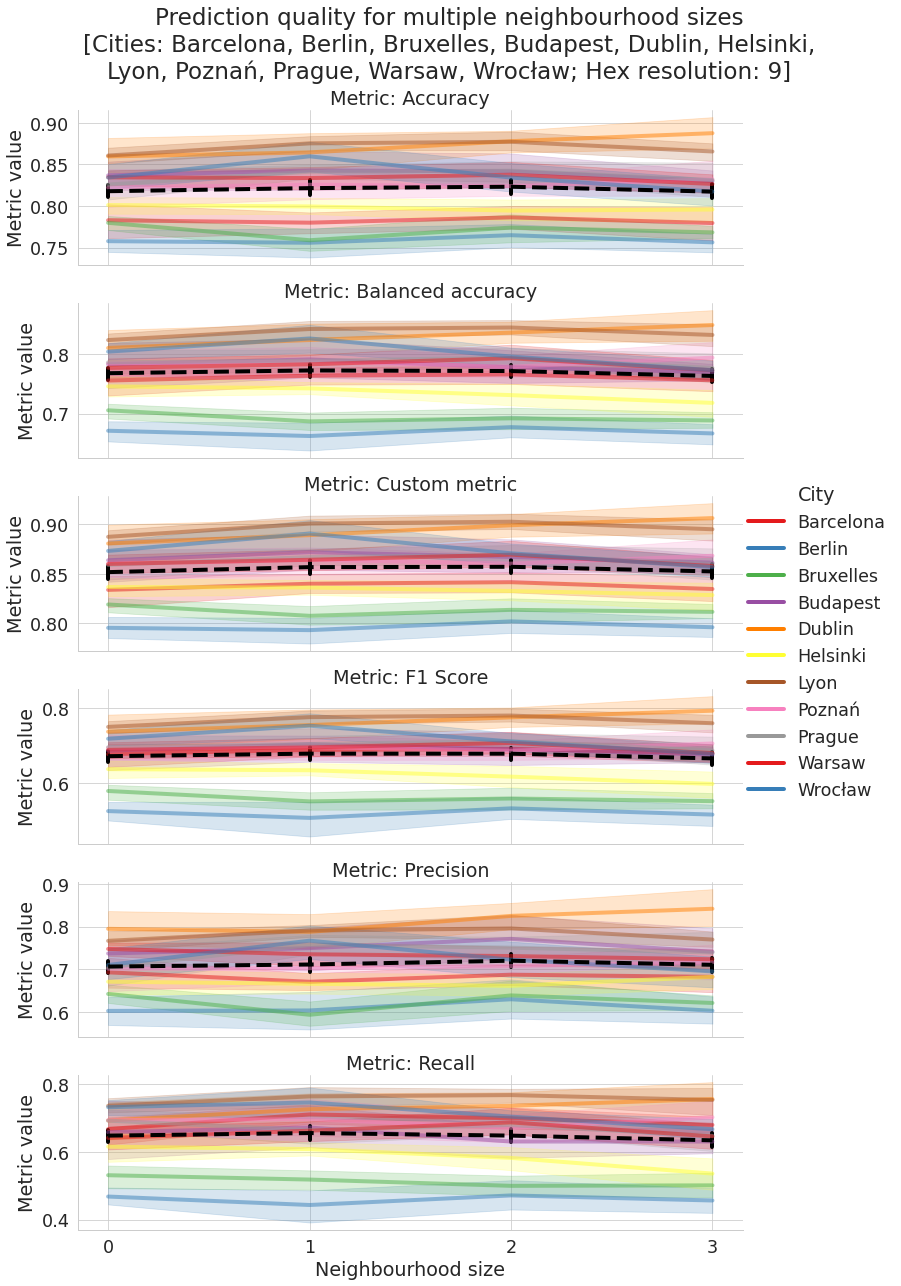

<ipython-input-14-5b5739938e90>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['neighbours_str'] = filtered_df.neighbours.astype(str)
Accuracy
Balanced accuracy
Custom metric
F1 Score
Precision
Recall


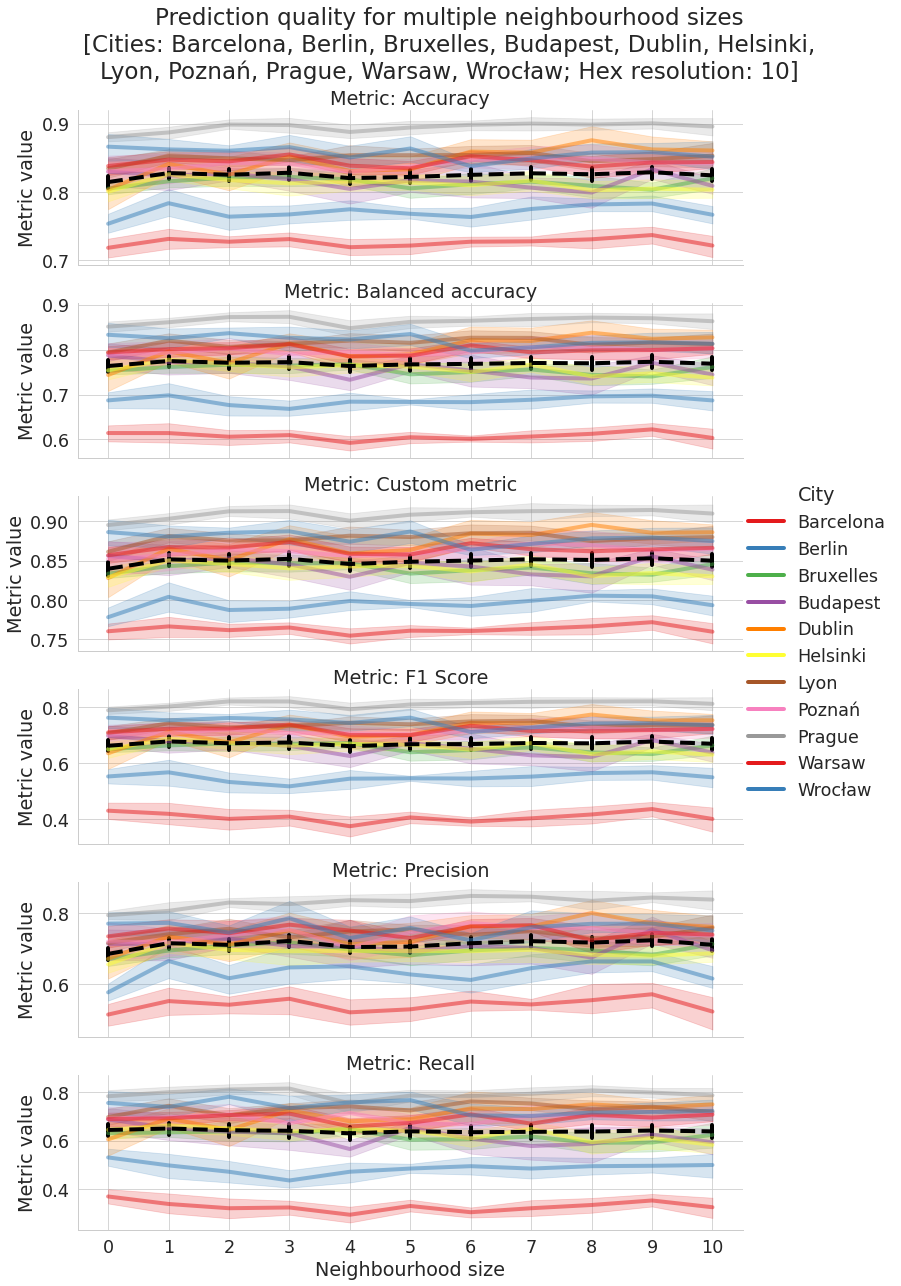

<ipython-input-14-5b5739938e90>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['neighbours_str'] = filtered_df.neighbours.astype(str)
Accuracy
Balanced accuracy
Custom metric
F1 Score
Precision
Recall


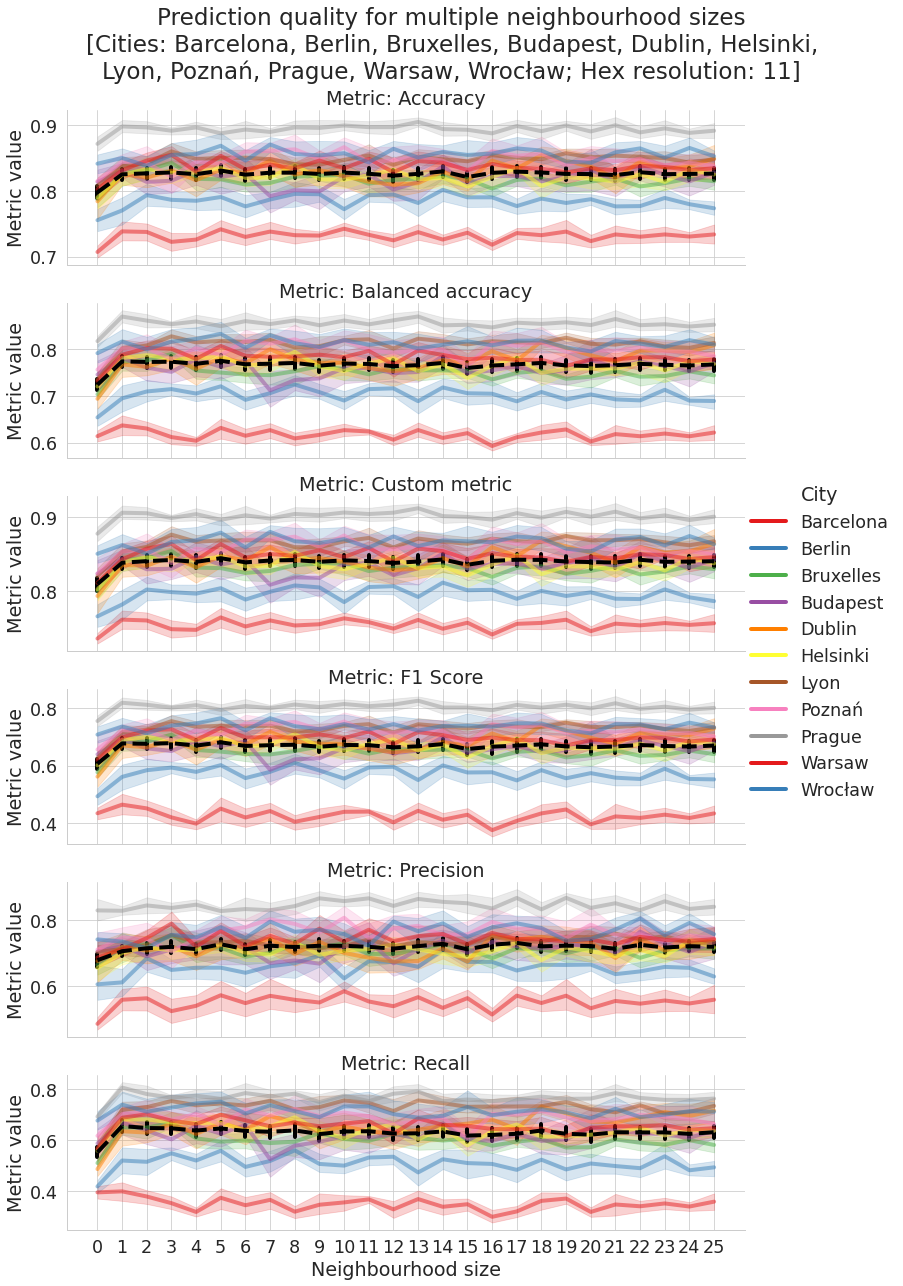

In [14]:
# sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 4})
# sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 2})
sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 4})
# with sns.plotting_context(font_scale=1.5):
for res in [9, 10, 11]:
# for metric in ['f1_score', 'accuracy', 'custom_metric']:
    # fig = plt.figure(figsize=(8.25, 11.75))
    filtered_df = df_flat.loc[
        # (df_flat.city == 'Wrocław') \
        (df_flat.resolution == res) \
        # (df_flat.resolution == res) \
        # & (df_flat.dataset_type == 'test') \
        & (df_flat.dataset_type == 'validation') \
        # & ((df_flat.classfier_cls == 'RandomForestClassifier') \
        # | (df_flat.classfier_cls == 'BalancedRandomForestClassifier') \
        # | (df_flat.classfier_cls =='BalancedSubsampleRandomForestClassifier')) \
        # & (df_flat.neighbours > 0) \
        # & (df_flat.inbalance_ratio == 1) \
        # & (df_flat.classfier_cls == 'RandomForestClassifier')
    ]
    # filtered_df['emb_cls'] = filtered_df.embedding_cls.astype(str)
    filtered_df['neighbours_str'] = filtered_df.neighbours.astype(str)
    a = np.arange(len(filtered_df.embedding_cls.unique()))
    # g = sns.violinplot(data=filtered_df,
    #     y="value",AdaBoostClassifier
    #     x="embedding_cls")
    g = sns.relplot(
        data=filtered_df,
        # x="embedding_cls",
        x="neighbours",
        # x="emb_cls",
        # x=a,
        # order="embedding_cls",
        y="value",
        # y="inbalance_ratio_str",
        # y="embedding_cls",
        # hue="neighbours",
        # hue="classfier_cls",
        hue="city",
        # size="neighbours",
        # linewidth=0,
        # hue="classfier_cls",
        # size="choice",
        # col="align",
        # kind="point",
        kind="line",
        # dodge=True,
        # capsize=.1,
        # kind="violin",
        # kind="scatter",
        # row="metric",
        # col="metric",
        row="metric",
        # size_order=["T1", "T2"],
        # palette=palette,
        # palette="flare",
        palette="Set1",
        height=3,
        aspect=3.5,
        # sharex=True,
        # sharey=False,
        facet_kws=dict(sharex=True, sharey=False),
        alpha=0.5
        # orient="h"
    )

    # # # iterate over axes of FacetGrid
    for (ax, metric) in zip(g.axes.flat, filtered_df.metric.unique()):
        print(metric)
        metrics_df = filtered_df.loc[filtered_df.metric == metric]
        sns.lineplot(ax=ax, data=metrics_df, x='neighbours', y='value', err_style="bars", color="k", ls='--', legend=None, label='Mean')
        # labels = ax.get_xticklabels() # get x labels
        # for i,l in enumerate(labels):
        #     if(i%2 == 0): labels[i] = '' # skip even labels
        ax.set(xticks=list(filtered_df.neighbours.unique()))

        # ax.set_yticklabels(list(embedding_clf_dict_rev.values())) # set new labels
        pass

    # ax2.plot(a, y) #we plot y as a function of a, which parametrizes x
    # g. set_ticks(a) #set the ticks to be a
    # g.set_ticklabels(filtered_df['emb_cls']) # change the ticks' names to x

    # g.set(xticks=a, xticklabels=filtered_df['emb_cls'])
    # plt.ylim(0, 1)

    # g.set_axis_labels("Density", f"Metric: {metric}")
    # g.map(mean_line, 'value', color='k', ls='--', alpha=0.5)
    # g.map(mean_line, res color='k', ls='--')
    g.set_axis_labels("Neighbourhood size", "Metric value")
    # g.set_axis_labels("Metric value", "Imbalance ratio")
    g.set_titles("Metric: {row_name}")
    # g.set_titles("Resolution: {row_name}\nMetric:\n{row_name}")
    # g.set_titles("{row_name}\nMetric: {col_name}")

    g.fig.subplots_adjust(wspace=0.1, hspace=0.25)
    g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
    g.fig.suptitle(f'Prediction quality for multiple neighbourhood sizes\n[Cities: Barcelona, Berlin, Bruxelles, Budapest, Dublin, Helsinki,\nLyon, Poznań, Prague, Warsaw, Wrocław; Hex resolution: {res}]')

    # # plt.legend(title='City')
    # handles = g._legend.legendHandles
    # line = mlines.Line2D([0], [0], label='Mean value', color="k", ls='--')
    # handles.append(line)
    # g._legend.legendHandles = handles

    g._legend.set_title("City")
    g._legend.get_title().set_multialignment('center')
    # plt.tight_layout()

    plt.savefig(f'neighbourhood_size_2_{res}.pdf', dpi=300, format='pdf', bbox_inches='tight')
    plt.show()

In [12]:
filtered_df = df_flat.loc[
    # (df_flat.city == 'Wrocław') \
    # (df_flat.resolution == res) \
    # (df_flat.resolution == res) \
    (((df_flat.resolution == 9) & (df_flat.neighbours == 2)) | ((df_flat.resolution == 10) & (df_flat.neighbours == 1)) | ((df_flat.resolution == 11) & (df_flat.neighbours == 5)))
    # & (df_flat.dataset_type == 'test') \
    & (df_flat.dataset_type == 'validation') \
    # & ((df_flat.classfier_cls == 'RandomForestClassifier') \
    # | (df_flat.classfier_cls == 'BalancedRandomForestClassifier') \
    # | (df_flat.classfier_cls =='BalancedSubsampleRandomForestClassifier')) \
    # & (df_flat.neighbours > 0) \
    # & (df_flat.inbalance_ratio == 1) \
    # & (df_flat.classfier_cls == 'RandomForestClassifier')
]
grpd = filtered_df.groupby(['metric', 'resolution', 'neighbours']).count()
grpd

city  inbalance_ratio  embedding_cls  \
metric            resolution neighbours                                         
Accuracy          9          2            110              110            110   
                  10         1            110              110            110   
                  11         5            110              110            110   
Balanced accuracy 9          2            110              110            110   
                  10         1            110              110            110   
                  11         5            110              110            110   
Custom metric     9          2            110              110            110   
                  10         1            110              110            110   
                  11         5            110              110            110   
F1 Score          9          2            110              110            110   
                  10         1            110              110            110   
                  11         5            110              110            110   
Precision         9          2            110              110            110   
                  10         1            110              110            110   
                  11         5            110              110            110   
Recall            9          2            110              110            110   
                  10         1            110              110            110   
                  11         5            110              110            110   

                                         neighbour_embedding_cls  processing  \
metric            resolution neighbours                                        
Accuracy          9          2                               110         110   
                  10         1                               110         110   
                  11         5                               110         110   
Balanced accuracy 9          2                               110         110   
                  10         1                               110         110   
                  11         5                               110         110   
Custom metric     9          2                               110         110   
                  10         1                               110         110   
                  11         5                               110         110   
F1 Score          9          2                               110         110   
                  10         1                               110         110   
                  11         5                               110         110   
Precision         9          2                               110         110   
                  10         1                               110         110   
                  11         5                               110         110   
Recall            9          2                               110         110   
                  10         1                               110         110   
                  11         5                               110         110   

                                         classfier_cls  iteration  \
metric            resolution neighbours                             
Accuracy          9          2                     110        110   
                  10         1                     110        110   
                  11         5                     110        110   
Balanced accuracy 9          2                     110        110   
                  10         1                     110        110   
                  11         5                     110        110   
Custom metric     9          2                     110        110   
                  10         1                     110        110   
                  11         5                     110        110   
F1 Score          9          2                     110      

In [13]:
def set_scale(x, **kwargs):
    ax = plt.gca()
    # print(x)
    metric = x.iloc[0]
    print(metric)
    tmp_df = filtered_df.loc[filtered_df.metric == metric]
    # print(tmp_df)
    # print(tmp_df.value.values.min(), tmp_df.value.values.max())
    ax.set_xlim(tmp_df.value.values.min(), tmp_df.value.values.max())

<ipython-input-14-ec880cd94227>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['ResNeigh'] = filtered_df.apply(lambda x: f"Resolution: {x['resolution']}\nNeighbourhood size: {x['neighbours']}", axis=1)
Accuracy
Accuracy
Accuracy
Balanced accuracy
Balanced accuracy
Balanced accuracy
Custom metric
Custom metric
Custom metric
F1 Score
F1 Score
F1 Score
Precision
Precision
Precision
Recall
Recall
Recall


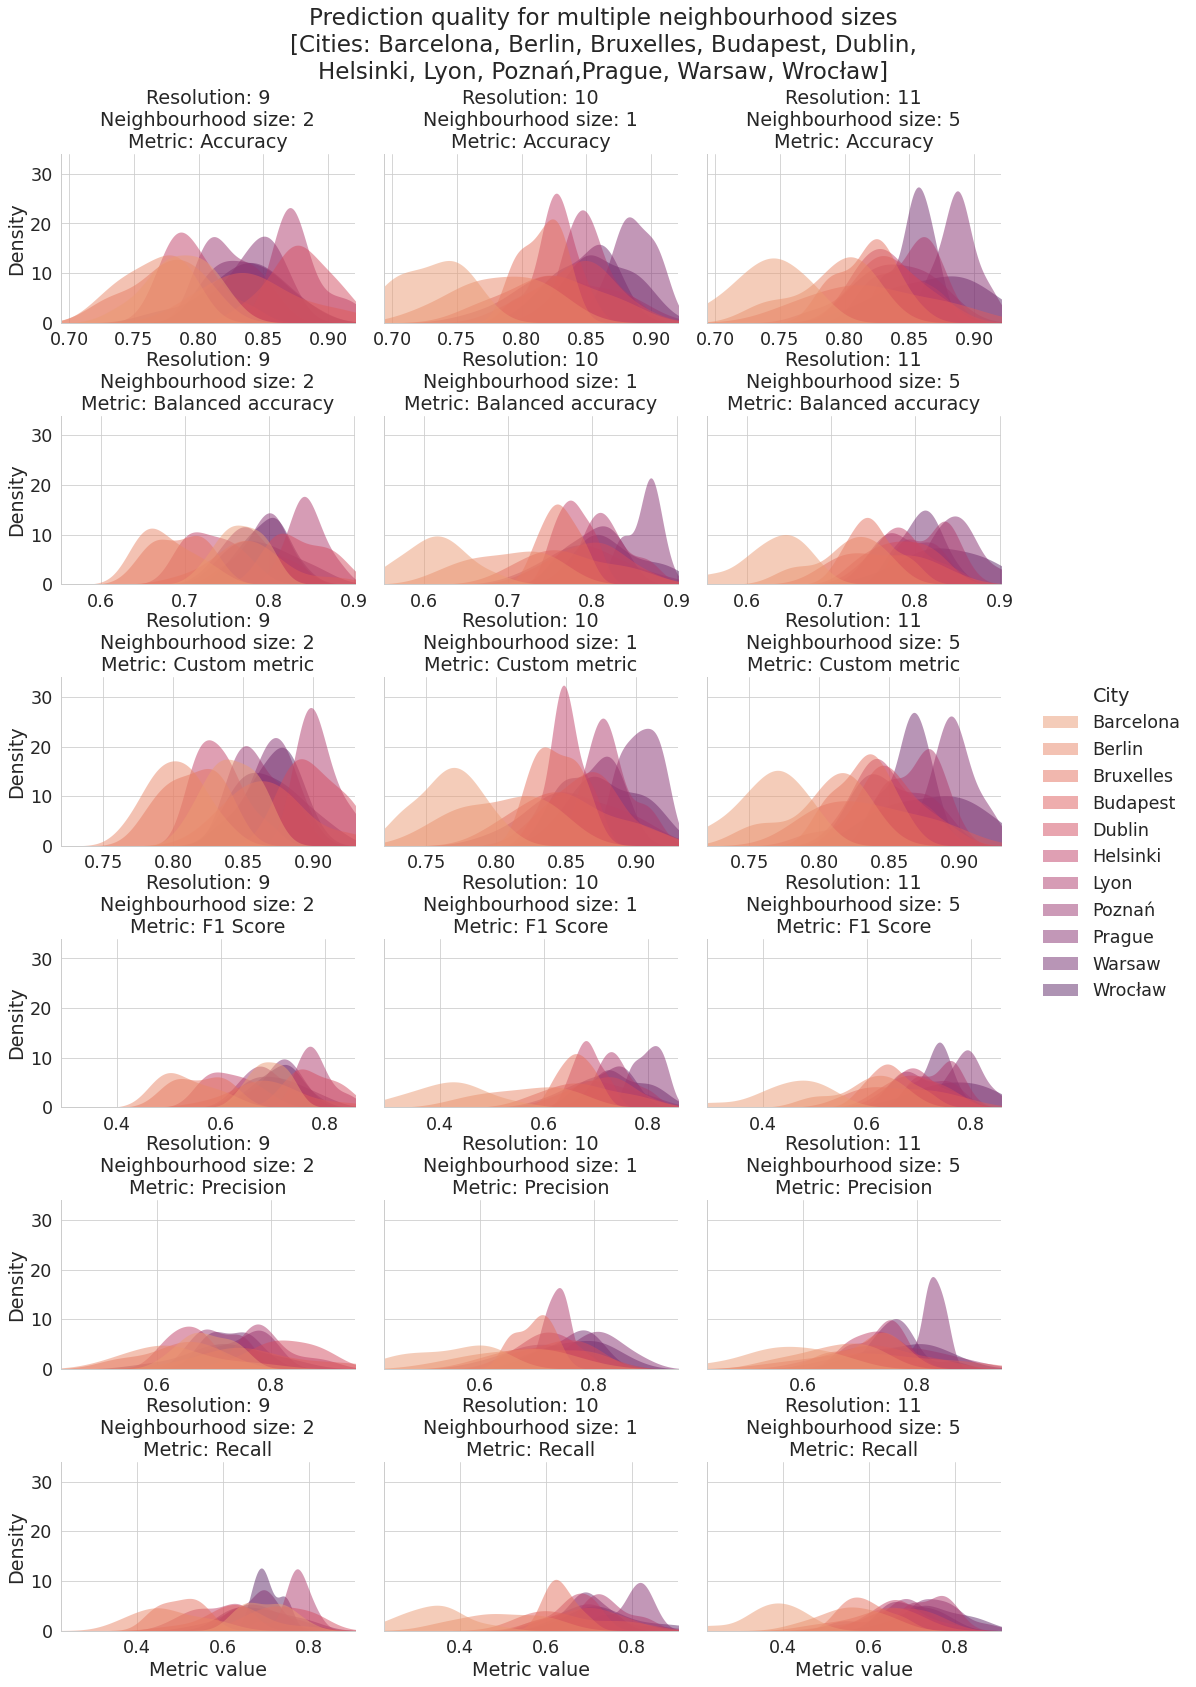

In [14]:
sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 4})
filtered_df = df_flat.loc[
    # (df_flat.city == 'Wrocław') \
    # (df_flat.resolution == res) \
    # (df_flat.resolution == res) \
    (((df_flat.resolution == 9) & (df_flat.neighbours == 2)) | ((df_flat.resolution == 10) & (df_flat.neighbours == 1)) | ((df_flat.resolution == 11) & (df_flat.neighbours == 5)))
    # & (df_flat.dataset_type == 'test') \
    & (df_flat.dataset_type == 'validation') \
    # & ((df_flat.classfier_cls == 'RandomForestClassifier') \
    # | (df_flat.classfier_cls == 'BalancedRandomForestClassifier') \
    # | (df_flat.classfier_cls =='BalancedSubsampleRandomForestClassifier')) \
    # & (df_flat.neighbours > 0) \
    # & (df_flat.inbalance_ratio == 1) \
    # & (df_flat.classfier_cls == 'RandomForestClassifier')
]
filtered_df['ResNeigh'] = filtered_df.apply(lambda x: f"Resolution: {x['resolution']}\nNeighbourhood size: {x['neighbours']}", axis=1)
g = sns.displot(
    data=filtered_df,
    # x="embedding_cls",
    x="value",
    # multiple="stack",
    # x="emb_cls",
    # x=a,
    # order="embedding_cls",
    # y="value",
    # y="inbalance_ratio_str",
    # y="embedding_cls",
    # hue="neighbours",
    # hue="classfier_cls",
    hue="city",
    # size="neighbours",
    # linewidth=0,
    # hue="classfier_cls",
    # size="choice",
    # col="align",
    # kind="point",
    kind="kde",
    # dodge=True,
    # capsize=.1,
    # kind="violin",
    # kind="scatter",
    # row="metric",
    col="ResNeigh",
    row="metric",
    # size_order=["T1", "T2"],
    # palette=palette,
    palette="flare",
    # palette="Set1",
    height=4,
    aspect=1.2,
    # sharex=True,
    # sharey=False,
    alpha=.5,
    common_norm=False, 
    fill=True, 
    linewidth=0,
    facet_kws=dict(sharex=False, sharey=True),
    # alpha=0.5
    # orient="h"
)

# # # # # iterate over axes of FacetGrid
# for (ax, metric) in zip(g.axes.flat, list(filtered_df.metric.unique()) * 3):
#     print(ax, metric)
#     # metrics_df = filtered_df.loc[filtered_df.metric == metric]
#     # sns.distplot(ax=ax, data=metrics_df, x='neighbours', y='value', err_style="bars", color="k", ls='--', legend=None, label='Mean')
#     # # labels = ax.get_xticklabels() # get x labels
#     # # for i,l in enumerate(labels):
#     # #     if(i%2 == 0): labels[i] = '' # skip even labels
#     # ax.set(xticks=list(filtered_df.neighbours.unique()))

#     # ax.set_yticklabels(list(embedding_clf_dict_rev.values())) # set new labels
#     pass

# ax2.plot(a, y) #we plot y as a function of a, which parametrizes x
# g. set_ticks(a) #set the ticks to be a
# g.set_ticklabels(filtered_df['emb_cls']) # change the ticks' names to x

# g.set(xticks=a, xticklabels=filtered_df['emb_cls'])
# plt.ylim(0, 1)

g.map(set_scale, 'metric', color='k', alpha=0.5)
g.set_axis_labels("Metric value", "Density")
# g.map(mean_line, res color='k', ls='--')
# g.set_axis_labels("Neighbourhood size", "Metric value")
# g.set_axis_labels("Metric value", "Imbalance ratio")
# g.set_titles("Metric: {row_name}")
# g.set_titles("Resolution: {row_name}\nMetric:\n{row_name}")
g.set_titles("{col_name}\nMetric: {row_name}")

g.fig.subplots_adjust(wspace=0.1, hspace=0.55)
g.fig.subplots_adjust(top=0.895) # adjust the Figure in rp
g.fig.suptitle(f'Prediction quality for multiple neighbourhood sizes\n[Cities: Barcelona, Berlin, Bruxelles, Budapest, Dublin,\nHelsinki, Lyon, Poznań,Prague, Warsaw, Wrocław]')

# # plt.legend(title='City')
# handles = g._legend.legendHandles
# line = mlines.Line2D([0], [0], label='Mean value', color="k", ls='--')
# handles.append(line)
# g._legend.legendHandles = handles

g._legend.set_title("City")
g._legend.get_title().set_multialignment('center')
# plt.tight_layout()

plt.savefig(f'neighbourhood_size_final_comparison.pdf', dpi=300, format='pdf', bbox_inches='tight')
plt.show()

In [23]:
sns.color_palette("Paired", 11)

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6)]

In [26]:
sns.color_palette("Set1", 11)

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 (0.6, 0.6, 0.6),
 (0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804)]